In [1]:
#### Importando las bibliotecas####
import numpy as np
from scipy.stats import poisson
from scipy.stats import norm
from scipy.integrate import odeint as ode
import scipy.optimize as optimize
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.integrate import odeint as ode

%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10

Cargamos los datos en $\textit{data}$ tenemos los puntos reales de nuestra observación, en $\textit{times}$ tenemos la secuencia de tiempo que corresponde a cada observación. La observación es el parámetro de número de infectados en el modelo SIR.

In [8]:
times = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
data = [7, 14, 86, 73, 119, 149, 121, 120, 71, 85, 15, 2, 9, 2, 3]

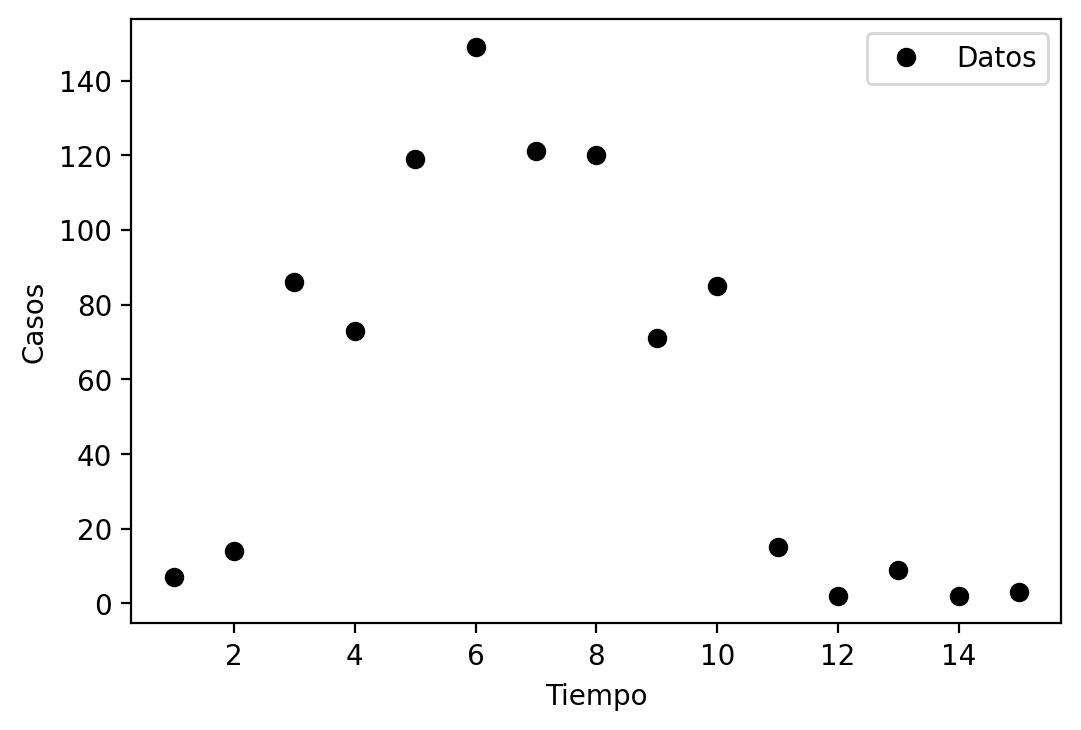

In [9]:
plt.plot(times, data, 'ko', linewidth=2, label='Datos')
plt.xlabel('Tiempo')
plt.ylabel('Casos')
plt.legend()
plt.show()

## Modelo epidemiológico SIR

Importamos algunas librerías necesarias, los archivos $ \textit{sir_ode}$, $ \textit{sir_cost}$ los escribimos nosotros mismos:


* $\textit{sir_ode:}$ resuelve la ecuación diferencial que define al modelo SIR:
    
 ${\displaystyle \frac {dS}{dt}}=- {\displaystyle \frac {\beta IS}{N}}$,

    ${\displaystyle\frac {dI}{dt}} ={\displaystyle \frac {\beta IS}{N}-\gamma I}$,

   ${\displaystyle\frac  {dR }{dt}}={\displaystyle\gamma I}$
    
Observe que la ecuación R es irrelevante para la dinámica de la epidemia y podemos eliminarla por completo, y 1. β solo ocurre en combinación con N, por lo que podemos combinar estos dos en un solo parámetro definiendo b = β / N

In [68]:
def model(ini, time_step, params):
	Y = np.zeros(3) #column vector for the state variables
	X = ini
	b= params[0]
	gamma = params[1] #beta/N
	#N=params[2]

	Y[0] = - b*X[0]*X[1] #S
	Y[1] = b*X[0]*X[1]  - gamma*X[1]  #I
	Y[2] = gamma*X[1]#R

	return Y

def x0fcn(params, data):
    
	S0 = 1.0 - (data[0]/params[2])
	I0 = data[0]/params[2]
	R0 = 0.0
	X0 = [S0, I0, R0]

	return X0



def yfcn(res, params):
	return res[:,1]*params[2]

Inicializamos los parámetros $\gamma$, $b$ 

Simulamos y graficamos el modelo.

In [69]:
params = [2.4, .3,1000]#make sure all the params and inition states are float
paramnames = ['b', 'gamma', 'k','N']
ini = x0fcn(params,data)
print(ini)

[0.993, 0.007, 0.0]


In [70]:
res = ode(model, ini, times, args=(params ,))
#print(res)
sim_measure =yfcn(res, params)


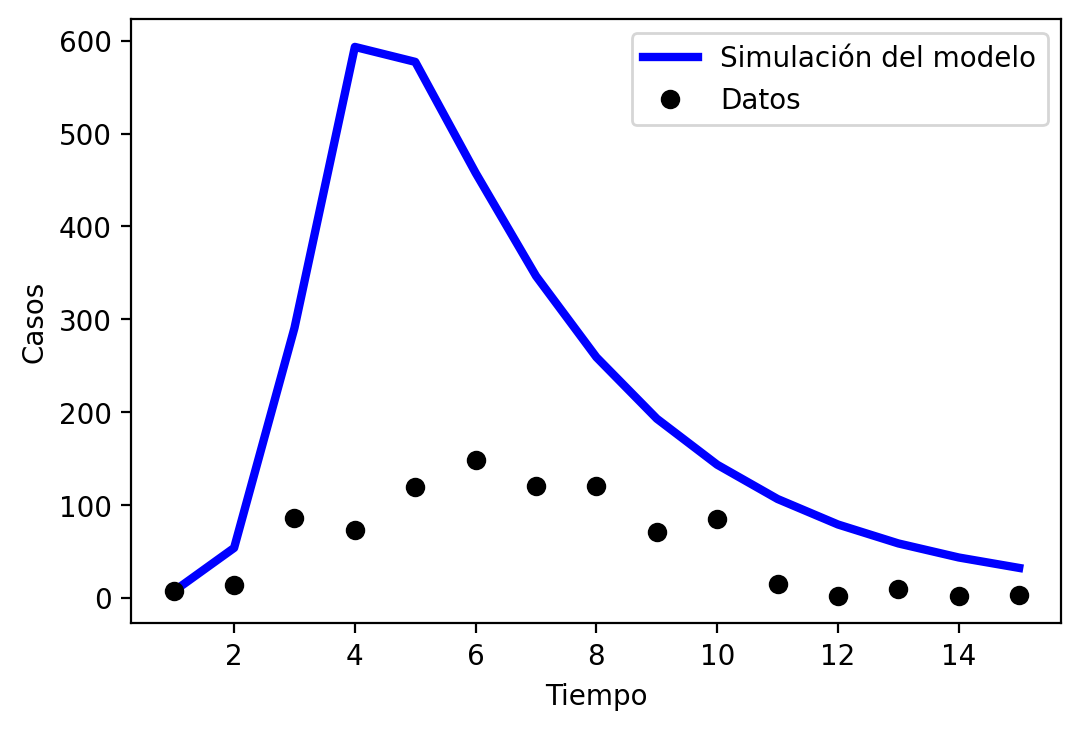

In [71]:

#print(sim_measure)
plt.plot(times, sim_measure, 'b-', linewidth=3, label='Simulación del modelo')
plt.plot(times, data, 'ko', linewidth=2, label='Datos')
plt.xlabel('Tiempo')
plt.ylabel('Casos')
plt.legend()
plt.show()

## Estimación Parametros $\gamma$ y $b$ para el modelo epidemiológico SIR

 Sea y ∗ t el número observado de infectados en el tiempo t y Yt sea la predicción del modelo. Entonces la probabilidad logarítmica es
$\log\mathbb{P}\left[{y^*_t|Y_t}\right] = \log{\left(\frac{1}{\sqrt{2\pi\sigma^2}}\,\exp{\left(-\frac{(y^*_t-Y_t)^2}{2\sigma^2}\right)}\right)} = -\tfrac{1}{2}\,\log{2\pi\sigma^2}-\tfrac{1}{2}\,\frac{(y^*_t-Y_t)^2}{\sigma^2}$

y

$\log\mathcal{L}= -\tfrac{1}{2}\,\left(\frac{1}{\sigma^2}\,\sum_{t}\!(y^*_t-Y_t)^2+\log{(\sigma^2)}+\log{(2\pi)}\right)$

Tenga en cuenta que MLE y mínimos cuadrados son equivalentes si los errores son normales con varianza constante.

In [111]:
def m_a(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
def NLL(params, data, times): #negative log likelihood
	params = np.abs(params)
	data = np.array(data)
	res = ode(model, x0fcn(params,data), times, args=(params,))
	y = yfcn(res, params)
	nll = sum((y - data)**2) # cuando sigma es constante
#	nll = -sum(np.log(poisson.pmf(np.round(data),np.round(y)))) # the round is b/c Poisson is for (integer) count data

	return nll


In [112]:
optimizer = optimize.minimize(NLL, params, args=(data, times), method='Nelder-Mead')
paramests = np.abs(optimizer.x)
iniests = x0fcn(paramests, data)
print(paramests)

[  1.58884052   0.6474666  635.10889468]


In [113]:
xest = ode(model, iniests, times, args=(paramests,))
est_measure = yfcn(xest, paramests)


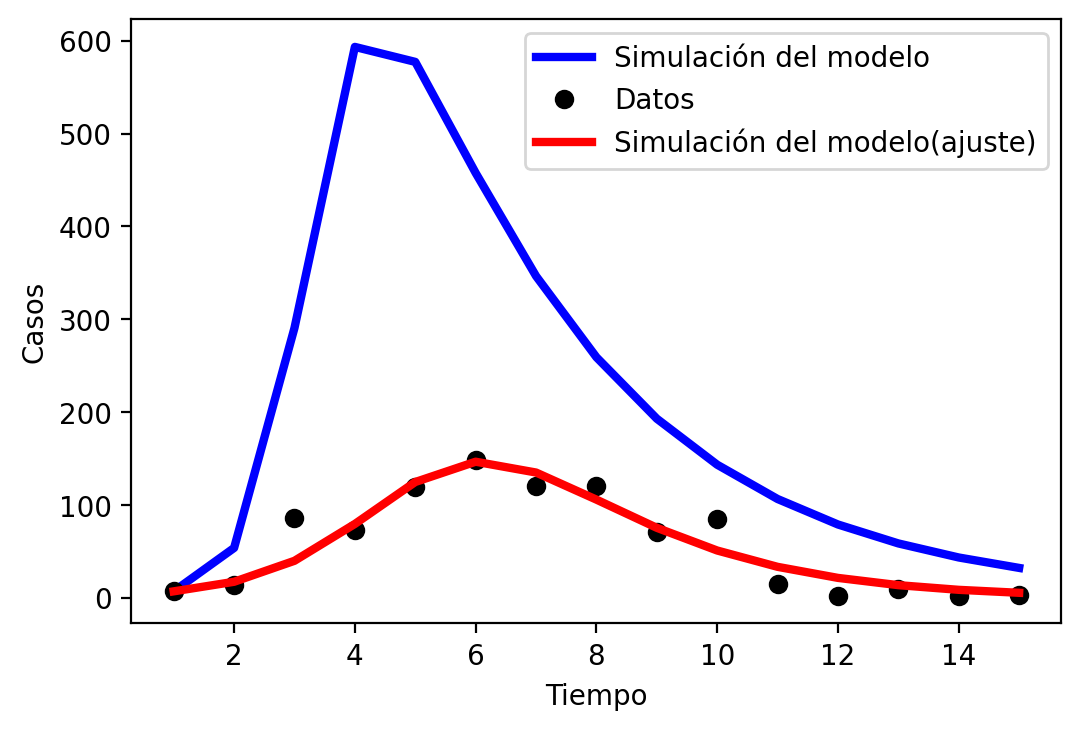

In [114]:
#print(sim_measure)
plt.plot(times, sim_measure, 'b-', linewidth=3, label='Simulación del modelo')
plt.plot(times, data, 'ko', linewidth=2, label='Datos')
plt.plot(times, est_measure, 'r-', linewidth=3, label='Simulación del modelo(ajusteMLE)')
plt.plot(times, est_measure, 'r-', linewidth=3, label='Simulación del modelo(ajuste)')

plt.xlabel('Tiempo')
plt.ylabel('Casos')
plt.legend()
plt.show()

Todo esto plantea la cuestión de cuál es realmente el mejor modelo para los errores. Por supuesto, la respuesta ciertamente dependerá de la naturaleza de los datos. La filosofía de la probabilidad nos anima a pensar en la cuestión de forma mecanicista. Cuando los datos, yt, son el resultado de un proceso de muestreo, por ejemplo, podemos pensar en ellos como muestras binomiales

$y_{t}∼Binomial(y_{t},\frac{n}{N})$

donde n es el tamaño de la muestra, N el tamaño de la población y es el número real de infecciones en el tiempo t. Alternativamente, podríamos pensar en yt como muestras de Poisson.

$y_{t}∼Poisson(p I_{t})$

donde el parámetro p refleja una combinación de la eficiencia del muestreo y la detectabilidad de infecciones. El último conduce a la siguiente función logarítmica de verosimilitud:
Ver mas detalles en: 

https://kingaa.github.io/short-course/parest/parest.html
